In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

## BIC Dataset

Access the BIC (Buckling Instability Classification) dataset through the following link:

[BIC Dataset](https://open.bu.edu/handle/2144/40085)

Run the following cell to download the dataset and unzip into the right folder.

In [19]:
!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/40085/BIC1.zip
!unzip -qq BIC1.zip 'BIC1/*' -d data/
!rm BIC1.zip

!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/40085/BIC2.zip
!unzip -qq BIC2.zip 'BIC2/*' -d data/
!rm BIC2.zip

!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/40085/BIC3.zip
!unzip -qq BIC3.zip 'BIC3/*' -d data/
!rm BIC3.zip

2022-12-02 15:28:37 URL:https://open.bu.edu/bitstream/handle/2144/40085/BIC1.zip [284717/284717] -> "BIC1.zip" [1]
2022-12-02 15:28:40 URL:https://open.bu.edu/bitstream/handle/2144/40085/BIC2.zip [589262/589262] -> "BIC2.zip" [1]
2022-12-02 15:28:44 URL:https://open.bu.edu/bitstream/handle/2144/40085/BIC3.zip [2808306/2808306] -> "BIC3.zip" [1]


### Model Training

After running each cell, predicted probability vectors for the test set (and calibration set for Neural Network only) will be save in the `results` folder.

##### Gaussian Process Classifier (GPC)

In [132]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [133]:
# A list of training set sizes used for training the model:
tr_sizes = [200, 500, 1000, 2000, 5000, 10000]

# Dataset versions:
datasets = [1, 2, 3]

for d_num in datasets:
    p = pathlib.Path(f'results/BIC{d_num}/GPC/')
    p.mkdir(parents=True, exist_ok=True)
    
    tr_set_input = np.loadtxt(f'data/BIC{d_num}/train_input_data.txt')
    tr_set_output = np.loadtxt(f'data/BIC{d_num}/train_output_data.txt')
    
    test_input = np.loadtxt(f'data/BIC{d_num}/test_input_data.txt')
    test_output = np.loadtxt(f'data/BIC{d_num}/test_output_data.txt')
    
    for tr_size in tr_sizes:
        train_input = tr_set_input[0:tr_size]
        train_output = tr_set_output[0:tr_size]

        kernel = 0.5 * RBF(1.0)
        gpc_model = GaussianProcessClassifier(kernel)
        gpc_model.fit(train_input, train_output)

        probs = gpc_model.predict_proba(test_input)

        np.save(f'results/BIC{d_num}/GPC/probs-tr_size-{tr_size}.npy', probs)

##### Support Vector Classifier (SVC)

In [134]:
from sklearn import svm

In [135]:
# A list of training set sizes used for training the model:
tr_sizes = [200, 500, 1000, 2000, 5000, 10000]

# Dataset versions:
datasets = [1, 2, 3]

for d_num in datasets:
    p = pathlib.Path(f'results/BIC{d_num}/SVC/')
    p.mkdir(parents=True, exist_ok=True)
    
    tr_set_input = np.loadtxt(f'data/BIC{d_num}/train_input_data.txt')
    tr_set_output = np.loadtxt(f'data/BIC{d_num}/train_output_data.txt')
    
    test_input = np.loadtxt(f'data/BIC{d_num}/test_input_data.txt')
    test_output = np.loadtxt(f'data/BIC{d_num}/test_output_data.txt')
    
    for tr_size in tr_sizes:
        train_input = tr_set_input[0:tr_size]
        train_output = tr_set_output[0:tr_size]

        svc_model = svm.SVC(probability=True, random_state=42)
        svc_model.fit(train_input, train_output)

        probs = svc_model.predict_proba(test_input)

        np.save(f'results/BIC{d_num}/SVC/probs-tr_size-{tr_size}.npy', probs)

##### Neural Network

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [92]:
# Define the network
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(16, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(200, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [136]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# A list of training set sizes used for training the model:
tr_sizes = [200]#, 500, 1000, 2000, 5000, 10000]

# Dataset versions:
datasets = [1, 2, 3]

for d_num in datasets:
    p = pathlib.Path(f'results/BIC{d_num}/NN')
    p.mkdir(parents=True, exist_ok=True)
    
    tr_set_input = np.loadtxt(f'data/BIC{d_num}/train_input_data.txt')
    tr_set_output = np.loadtxt(f'data/BIC{d_num}/train_output_data.txt')
    
    for tr_size in tr_sizes:
        train_input = tr_set_input[0:tr_size]
        train_output = tr_set_output[0:tr_size]

        cal_input = tr_set_input[10000:11000]
        cal_output = tr_set_output[10000:11000]

        val_input = tr_set_input[20000:21000]
        val_output = tr_set_output[20000:21000]

        test_input = np.loadtxt(f'data/BIC{d_num}/test_input_data.txt')

        # Normalize inputs:
        mu = np.mean(train_input, axis=0)
        std = np.std(train_input, axis=0)

        train_input = torch.tensor((train_input - mu) / std).to(torch.float)
        cal_input = torch.tensor((cal_input - mu) / std).to(torch.float)
        val_input = torch.tensor((val_input - mu) / std).to(torch.float)
        test_input = torch.tensor((test_input - mu) / std).to(torch.float)
        
        # TRAIN THE NEURAL NETWORK
        train_output = torch.tensor(train_output).to(torch.long)
        train_output = nn.functional.one_hot(train_output).to(torch.float)
        cal_output = torch.tensor(cal_output).to(torch.long)
        cal_output = nn.functional.one_hot(cal_output).to(torch.float)
        val_output = torch.tensor(val_output).to(torch.long)
        val_output = nn.functional.one_hot(val_output).to(torch.float)
        
        training_set = TensorDataset(train_input, train_output)
        cal_set = TensorDataset(cal_input, cal_output)
        val_set = TensorDataset(val_input, val_output)
        
        train_dataloader = DataLoader(training_set, batch_size=256, shuffle=True)
        cal_dataloader = DataLoader(cal_set, batch_size=1000, shuffle=False)
        val_dataloader = DataLoader(val_set, batch_size=1000, shuffle=False)
        
        for model_num in range(10):
            torch.manual_seed(model_num + 42)
            mlp = MLP()
            mlp.to(dev)
            mlp.train()

            loss_function = nn.CrossEntropyLoss(reduction='sum')
            optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=0.0)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
            
            training_error = []
            cal_error = []
            val_error = []
            for epoch in range(0, 50):
                mlp.train()
                sum_loss = 0.0
                for inputs, targets in train_dataloader:
                    inputs = inputs.to(dev)
                    targets = targets.to(dev)
                    optimizer.zero_grad()
                    outputs = mlp(inputs)
                    loss = loss_function(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                training_error.append(sum_loss / tr_size)

                mlp.eval()
                with torch.no_grad():
                    sum_loss_val = 0
                    for input, output in val_dataloader:
                        loss = loss_function(mlp(input), output)
                        sum_loss_val += loss.item()
                    val_error.append(sum_loss_val / 1000)    
                    sum_loss_cal = 0
                    for input, output in cal_dataloader:
                        loss = loss_function(mlp(cal_input), cal_output)
                        sum_loss_cal += loss.item()
                    cal_error.append(sum_loss_cal / 1000)
    
                scheduler.step()
            
            #plt.plot(np.log(training_error), 'k')
            #plt.plot(np.log(cal_error), 'r')
            #plt.plot(np.log(val_error), 'b')
            #plt.show()

            mlp.eval()
            with torch.no_grad():
                cal_logits = mlp(cal_input)
                probs = torch.softmax(cal_logits, axis=1)
            
            np.save(f'results/BIC{d_num}/NN/probs-cal-tr_size-{tr_size}-model_num-{model_num}.npy', probs)

            mlp.eval()
            with torch.no_grad():
                test_logits = mlp(test_input)
                probs = torch.softmax(test_logits, axis=1)
            
            np.save(f'results/BIC{d_num}/NN/probs-test-tr_size-{tr_size}-model_num-{model_num}.npy', probs)


# ABC Dataset

For details of model training check out [ABC_Dataset](https://github.com/pprachas/ABC_dataset) repository on GitHub.

We have logits of trained models in this repo.

In [10]:
# Dataset versions:
datasets = [1, 2, 3]

for d_num in datasets:
    p = pathlib.Path(f'results/ABC{d_num}/NN')
    p.mkdir(parents=True, exist_ok=True)
    
    logits_cal = np.load(f'data/ABC{d_num}/logits_val.npy')[:,:1000]
    probs_cal = np.exp(logits_cal) / np.sum(np.exp(logits_cal), axis=2, keepdims=True)

    logits_test = np.load(f'data/ABC{d_num}/logits_test.npy')
    probs_test = np.exp(logits_test) / np.sum(np.exp(logits_test), axis=2, keepdims=True)
    
    for model_num in range(10):
        np.save(f'results/ABC{d_num}/NN/probs-cal-model_num-{model_num}.npy', probs_cal[model_num])
        np.save(f'results/ABC{d_num}/NN/probs-test-model_num-{model_num}.npy', probs_test[model_num])

# Crack Path Dataset

Access the Mechanical MNIST Crack Path dataset through the following link:

[Crack Path Dataset](https://open.bu.edu/handle/2144/42757)

Manually download

- `mat-dist-train.7z`

- `mat-dist-test.7z`

- `dmg-train-64x64.7z`

- `dmg-test-64x64.7z`

and extract them into the `data/` folder.

Or, run the two cells below to download and process the dataset. This may take approximately 30 minutes to complete.

In [148]:
!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/42757/mat-dist-train.7z
!7z x mat-dist-train.7z -o./data/Crack-Path/ > log
!rm mat-dist-train.7z

!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/42757/mat-dist-test.7z
!7z x mat-dist-test.7z -o./data/Crack-Path/ > log
!rm mat-dist-test.7z

!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/42757/dmg-train-64x64.7z
!7z x dmg-train-64x64.7z -o./data/Crack-Path/ > log
!rm dmg-train-64x64.7z

!wget --no-verbose https://open.bu.edu/bitstream/handle/2144/42757/dmg-test-64x64.7z
!7z x dmg-test-64x64.7z -o./data/Crack-Path/ > log
!rm dmg-test-64x64.7z

2022-12-06 19:32:04 URL:https://open.bu.edu/bitstream/handle/2144/42757/dmg-train-64x64.7z [3817372/3817372] -> "dmg-train-64x64.7z" [1]
2022-12-06 19:39:28 URL:https://open.bu.edu/bitstream/handle/2144/42757/dmg-test-64x64.7z [639023/639023] -> "dmg-test-64x64.7z" [1]


In [151]:
dmgs_train = np.zeros((60000, 64, 64))
mats_train = np.zeros((60000, 64, 64))
for i in range(60000):
    dmgs_train[i] = np.loadtxt(f'data/Crack-Path/dmg-train-64x64/dmg{i}.txt')
    mats_train[i] = np.loadtxt(f'data/Crack-Path/mat-dist-train/mat{i}.txt')

dmgs_test = np.zeros((10000, 64, 64))
mats_test = np.zeros((10000, 64, 64))
for i in range(10000):
    dmgs_test[i] = np.loadtxt(f'data/Crack-Path/dmg-test-64x64/dmg{i}.txt')
    mats_test[i] = np.loadtxt(f'data/Crack-Path/mat-dist-test/mat{i}.txt')

np.save('data/Crack-Path/mat-train.npy', mats_train)
np.save('data/Crack-Path/dmg-train.npy', dmgs_train)
np.save('data/Crack-Path/mat-test.npy', mats_test)
np.save('data/Crack-Path/dmg-test.npy', dmgs_test)

del mats_train, dmgs_train, mats_test, dmgs_test 

### Model Training
\* Note that we have the weights of the trained models in this repository so you can use them and skip the training phase. Go to [Testing](#testing)

In [4]:
import torch
from torch import nn
import random
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

##### Define the UNet Model

In [5]:
class UNet(nn.Module):
    def __init__(self, c):
        super(UNet, self).__init__()
        # Convolutional Block in Encoder Section at Level i: ei   --   Decoder Section: di
        # input: 64x64
        self.e01 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn01 = nn.BatchNorm2d(num_features=c)
        self.e02 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn02 = nn.BatchNorm2d(num_features=c)
        
        # input: #32x32
        self.e11 = nn.Conv2d(in_channels=c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(num_features=2*c)
        self.e12 = nn.Conv2d(in_channels=2*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn12 = nn.BatchNorm2d(num_features=2*c)
        
        # input: 16x16
        self.e21 = nn.Conv2d(in_channels=2*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn21 = nn.BatchNorm2d(num_features=4*c)
        self.e22 = nn.Conv2d(in_channels=4*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn22 = nn.BatchNorm2d(num_features=4*c)
        
        # input: 8x8
        self.e31 = nn.Conv2d(in_channels=4*c, out_channels=8*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(num_features=8*c)
        self.e32 = nn.Conv2d(in_channels=8*c, out_channels=8*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(num_features=8*c)
        
        # input: 16x16
        self.d21 = nn.Conv2d(in_channels=8*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn23 = nn.BatchNorm2d(num_features=4*c)
        self.d22 = nn.Conv2d(in_channels=4*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn24 = nn.BatchNorm2d(num_features=4*c)
        
        # input: 32x32
        self.d11 = nn.Conv2d(in_channels=4*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn13 = nn.BatchNorm2d(num_features=2*c)
        self.d12 = nn.Conv2d(in_channels=2*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn14 = nn.BatchNorm2d(num_features=2*c)
        
        # input: 64x64
        self.d01 = nn.Conv2d(in_channels=2*c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn03 = nn.BatchNorm2d(num_features=c)
        self.d02 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn04 = nn.BatchNorm2d(num_features=c)
        
        # Increaseing the resolution of image from a lower level to match the upper level
        self.upconv3 = nn.ConvTranspose2d(in_channels=8*c, out_channels=4*c, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(in_channels=4*c, out_channels=2*c, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(in_channels=2*c, out_channels=c, kernel_size=2, stride=2)

        # Output
        self.out = nn.Conv2d(in_channels=c, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        x0 = self.relu(self.bn02(self.e02(self.relu(self.bn01(self.e01(x))))))
        x = self.maxpool(x0)

        x1 = self.relu(self.bn12(self.e12(self.relu(self.bn11(self.e11(x))))))
        x = self.maxpool(x1)
        
        x2 = self.relu(self.bn22(self.e22(self.relu(self.bn21(self.e21(x))))))
        x = self.maxpool(x2)
        
        x = self.relu(self.bn32(self.e32(self.relu(self.bn31(self.e31(x))))))
        
        # decoder
        x = torch.cat((self.upconv3(x), x2), dim=1)
        x = self.relu(self.bn24(self.d22(self.relu(self.bn23(self.d21(x))))))

        x = torch.cat((self.upconv2(x), x1), dim=1)
        x = self.relu(self.bn14(self.d12(self.relu(self.bn13(self.d11(x))))))

        x = torch.cat((self.upconv1(x), x0), dim=1)
        x = self.relu(self.bn04(self.d02(self.relu(self.bn03(self.d01(x))))))

        out = self.out(x)

        return out

##### Define Utility Functions

In [6]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()

        out = model(x)
        
        loss = loss_fn(out, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        return loss

    return train_step

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, target, smooth=0.5):
        gt_onehot = F.one_hot(target.reshape(-1, 64, 64).to(torch.long), 2).permute(0, 3, 1, 2)
        inputs = torch.softmax(inputs, axis=1)       
        
        dice_loss = - (2. * (inputs * gt_onehot).sum() + smooth) / ((inputs + gt_onehot).sum() + smooth)
        
        return 1 + dice_loss

##### Load the Dataset

In [23]:
tr_size = 10000
val_size = 1000
cal_size = 1000

tr_input = np.load('data/Crack-Path/mat-train.npy').reshape(-1, 1, 64, 64)
tr_output = np.load('data/Crack-Path/dmg-train.npy').reshape(-1, 1, 64, 64)

train_input = tr_input[:tr_size]
train_output = tr_output[:tr_size]

val_input = tr_input[10000:10000+val_size]
val_output = tr_output[10000:10000+val_size]

cal_input = tr_input[20000:20000+cal_size]
cal_output = tr_output[20000:20000+cal_size]

del tr_input, tr_output

test_input = np.load('data/Crack-Path/mat-test.npy').reshape(-1, 1, 64, 64)
test_output = np.load('data/Crack-Path/dmg-test.npy').reshape(-1, 1, 64, 64)

mu = np.mean(train_input)
std = np.std(train_input)

train_input = torch.tensor((train_input-mu)/std, dtype=torch.double)
train_output = torch.tensor(train_output, dtype=torch.double)
val_input = torch.tensor((val_input-mu)/std, dtype=torch.double)
val_output = torch.tensor(val_output, dtype=torch.double)
cal_input = torch.tensor((cal_input-mu)/std, dtype=torch.double)
cal_output = torch.tensor(cal_output, dtype=torch.double)
test_input = torch.tensor((test_input-mu)/std, dtype=torch.double)
test_output = torch.tensor(test_output, dtype=torch.double)

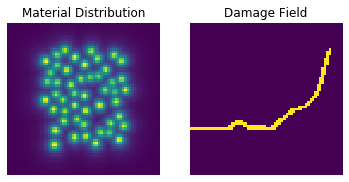

In [24]:
_, axs = plt.subplots(1, 2)
for ax in axs:
    ax.axis('off')
axs[0].set_title('Material Distribution')
axs[1].set_title('Damage Field')
input_plot = axs[0].imshow(torch.flip(train_input[5, 0], (0,)))
output_plot = axs[1].imshow(torch.flip(train_output[5, 0], (0,)))

##### Training Process

In [46]:
def training(epochs, learning_rate, decay_rate, decay_step, batch_size, channels, model_name):
    p = pathlib.Path(f'results/Crack-Path/best_models/')
    p.mkdir(parents=True, exist_ok=True)
    
    # data
    train_loader = DataLoader(TensorDataset(train_input, train_output), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_input, val_output), batch_size=batch_size, shuffle=False)
    
    # GPU
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    model = UNet(channels)
    model.double()
    # remove comment if you are using more than one GPU
    #model = nn.DataParallel(model, device_ids = [0])
    model.to(dev)

    min_val_loss = np.inf
    
    loss_fn = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_rate)

    train_step = make_train_step(model, loss_fn, optimizer)

    train_loss = [] # recording training error after each epoch
    val_loss = [] # recording validation error after each epoch
    for epoch in range(epochs):
        loss = 0
        n_batches = 0
        # 1 training epoch
        for x_batch, y_batch in train_loader:
            n_batches += 1
            x_batch = x_batch.to(dev)
            y_batch = y_batch.to(dev)
            l = train_step(x_batch, y_batch)
            if n_batches % 100 == 0:
                print(f"epoch {epoch+1}/{epochs} | batch {n_batches} | batch loss: {l.item()}")
            loss += l * len(x_batch)
        scheduler.step()
        train_loss = np.append(train_loss, loss.item()/(tr_size))

        # Validation error calculation
        with torch.no_grad():
            loss_val = 0
            n_batches_val = 0
            for x_batch_val, y_batch_val in val_loader:
                n_batches_val += 1
                x_batch_val = x_batch_val.to(dev)
                y_batch_val = y_batch_val.to(dev)
                model.eval()
                val_out = model(x_batch_val)
                loss_val += loss_fn(val_out, y_batch_val) * len(x_batch_val)

        val_loss = np.append(val_loss, loss_val.item()/(val_size))
        print('epoch: ', epoch+1, '  |  loss (training): ', loss.item()/(tr_size), '  |  loss (validation): ', loss_val.item()/(val_size), end='\r')

        is_best = False
        if min_val_loss > val_loss[-1]:
            is_best = True
            min_val_loss = val_loss[-1]
    
        if is_best:
            torch.save(model.state_dict(), f'results/Crack-Path/best_models/{model_name}.pt')

    print('epoch: ', epoch+1, '  |  loss (training): ', loss.item()/(tr_size), '  |  loss (validation): ', loss_val.item()/(val_size))

##### Training 10 UNet models on the Crack Path dataset with random initialization.

\* Note that without a GPU this training can take a long time.

In [ ]:
for i in range(10):
    print(f'Training model {i}')
    torch.manual_seed(i)
    random.seed(i)
    np.random.seed(i)
    training(epochs=50, learning_rate=0.0001, decay_rate=1, decay_step=50, batch_size=32, channels=32, model_name=f'unet-{i}')

### Testing
<a id='testing'></a>

##### Compute and save predicted probabilities

In [50]:
cal_loader = DataLoader(TensorDataset(cal_input, cal_output), batch_size=10, shuffle=False)
test_loader = DataLoader(TensorDataset(test_input, test_output), batch_size=10, shuffle=False)

In [ ]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

p = pathlib.Path(f'results/Crack-Path/NN/')
p.mkdir(parents=True, exist_ok=True)    

for m in range(10):
    model = UNet(32)
    model.load_state_dict(torch.load(f'unet-{m}.pt'))
    model.double()
    # remove comment if you are using more than one GPU
    #model = nn.DataParallel(model, device_ids = [0])
    model.to(dev)
    model.eval()

    cal_probs = []
    with torch.no_grad():
        for x, _ in cal_loader:
            x = x.to(dev)
            probs = torch.softmax(model(x), axis=1)
            cal_probs.append(probs.permute(0, 2, 3, 1).flatten(0, -2).cpu().detach().numpy())
    cal_probs = np.concatenate(cal_probs, axis=0)
    np.save(f'results/Crack-Path/NN/probs-cal-model_num-{m}.npy', cal_probs)
    
    test_probs = []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(dev)
            probs = torch.softmax(model(x), axis=1)
            test_probs.append(probs.permute(0, 2, 3, 1).flatten(0, -2).cpu().detach().numpy())
    test_probs = np.concatenate(test_probs, axis=0)
    np.save(f'results/Crack-Path/NN/probs-test-model_num-{m}.npy', test_probs)
    